# T5 Fine-Tunning for recommendations

T5 fine-tuning for recomendations. It is very simple to adapt this model to other tasks such as recommendations, summaries, etc. See the paper for more details: [Exploring the Limits of Transfer Learning with a Unified
Text-to-Text Transformer](https://arxiv.org/pdf/1910.10683.pdf)

## Referencies

* [Huggingface T5 documentation](https://huggingface.co/docs/transformers/v4.35.1/en/model_doc/t5#t5)
* [T5 Fine tunning](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb#scrollTo=SDVQ04fGRb1v)
* [Exploring the Limits of Transfer Learning with a UnifiedText-to-Text Transformer](https://arxiv.org/pdf/1910.10683.pdf)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append(f'./src')

import seaborn as sns


import util as ut 
import model as ml

import numpy as np
import pandas as pd

import dataset as ds
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
    
from transformers import T5Tokenizer

import nltk
from bunch import Bunch

import torch
from torch.utils.data import Dataset, DataLoader

from scipy import stats

## Setup

In [3]:
ut.set_seed(42)

In [4]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [6]:
torch.backends.cuda.matmul.allow_tf32 = True

## Helper Functons and classes

In [7]:
def zscore(df, column): 
    df['zscore'] = np.abs(stats.zscore(df[column]))
    return df

In [8]:
class ObservationBuilder:
    def  __init__(self, ds, n_recs):
        self.ds     = ds
        self.n_recs = n_recs

    def __call__(self, user_id):
        seen_items = self.ds.items_by_user(user_id)        
        if len(seen_items) == 0:
            return None

        seen  = '\n'.join(seen_items[:-self.n_recs])
        
        source = f"""MOVIES SEEN HISTORY WITH RATING:\n\n{seen}\n\n\n
CANDIDATES MOVIES TO RECOMMEND:\n\n{','.join(self.ds.items)}.\n
RECOMMEND {self.n_recs} MOVIES:
"""
        target = '\n'.join([i.split(':')[0].strip() for i in seen_items[-self.n_recs:]])

        return Bunch({'source':source, 'target':target })

## Prepare Dataset

In [10]:
items = pd.read_json('./datasets/movies.json')
interactions = pd.read_json('./datasets/interactions.json')

,count,mean,std,min,25%,50%,75%,max
count,1633.0,79.600122,79.185583,30.0,38.0,56.0,90.0,1524.0


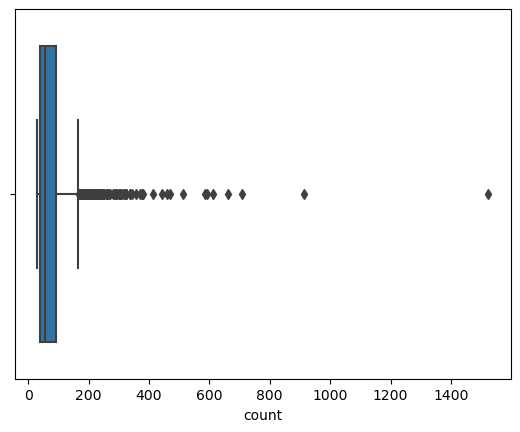

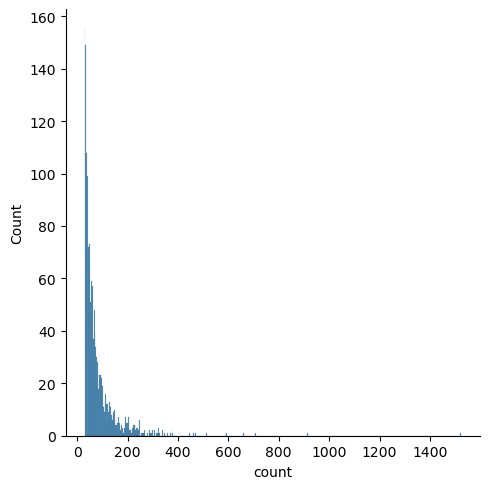

In [11]:
movie_ints = interactions['movie_id'].value_counts().reset_index(name='count')
movie_ints = zscore(movie_ints, 'count')

movie_ints = movie_ints[movie_ints['count']  >= 30 ]

sns.boxplot(movie_ints, x='count')
sns.displot(movie_ints, x='count', binwidth=3)

movie_ints \
    .loc[:, ~movie_ints.columns.isin(['movie_id', 'zscore'])] \
    .describe() \
    .transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,3044.0,80968.130749,46373.895030,87.0,41908.25,81076.0,120831.25,162400.0
count,3044.0,22.915572,19.484528,6.0,9.00,15.0,30.00,100.0


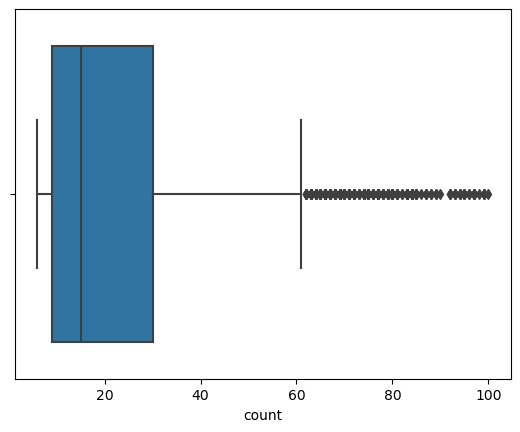

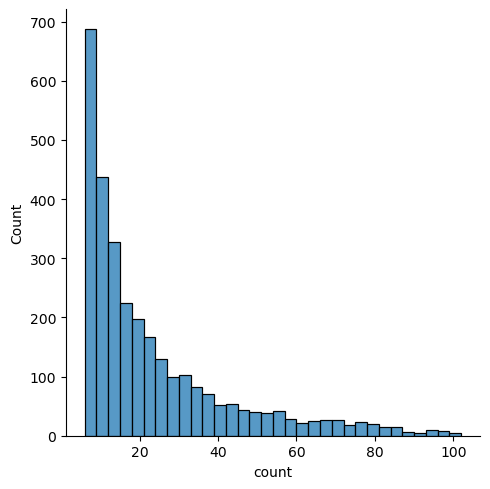

In [12]:
interactions = interactions[interactions['movie_id'].isin(movie_ints.movie_id.unique())] 

user_ints = interactions['user_id'] \
    .value_counts() \
    .reset_index(name='count')

user_ints = zscore(user_ints, 'count')

user_ints = user_ints[user_ints['zscore'] < 2.5 ]
user_ints = user_ints[user_ints['count'] >= 6 ]

sns.boxplot(x=user_ints['count'])

sns.displot(user_ints, x='count', binwidth=3)

user_ints \
    .loc[:, ~user_ints.columns.isin(['movie_id', 'zscore'])] \
    .describe() \
    .transpose()

In [13]:
interactions = interactions[interactions['user_id'].isin(user_ints.user_id.unique())]

In [14]:
interactions.shape

(69755, 7)

In [74]:
class RecommendationsDataset:
    def __init__(self, interactions, items):
        self.items_list = []
        self.user_items = {}
        
        self.data =  interactions.merge(items, left_on='movie_id', right_on='id')[['timestamp', 'user_id', 'movie_id', 'rating', 'title']]

        self.data['interaction_text'] =  self.data['title'].apply(lambda x: x.strip()) + ': ' +  self.data['rating'].astype(str)

        self.data['movie_text'] =  self.data['title'].apply(lambda x: x.strip())

        self.data = self.data[['user_id', 'movie_id', 'timestamp', 'rating', 'interaction_text', 'movie_text']]


    @property
    def users(self): return self.data['user_id'].unique()


    def items_by_user(self, user_id):
        if user_id in self.user_items:
            return self.user_items[user_id]
        else:
            items = self.data  \
                .query(f'user_id  == {user_id}') \
                .sort_values('timestamp', ascending=False) \
                ['interaction_text'].values
            self.user_items[user_id] = items
            return items


    @property
    def items(self): 
        if len(self.items_list) > 0:
            return self.items_list
        
        self.items_list = ds.data \
            .groupby(['movie_text'], as_index=False)['rating'] \
            .mean() \
            .sort_values(['rating'], ascending=False)['movie_text'] \
            .values

        return self.items_list


    def observations(self):
        obs = []
        for u in self.users:
            obs.extend(self.user_observation(u))
        return pd.DataFrame(obs)


    def user_observation(self, user_id):
        seen_items = self.items_by_user(user_id)        
        if len(seen_items) == 0:
            return None

        all_items = ','.join(self.items)
        
        obs = []
        previous = []
        for idx, item in enumerate(seen_items):
            if idx >= 1:
                seen  = '\n'.join(previous)
                source = f"""MOVIES SEEN HISTORY WITH RATING:\n{seen}\n\n
CANDIDATES MOVIES TO RECOMMEND:\n{all_items}.\n
RECOMMEND:
"""
                obs.append(Bunch({'source':source, 'target':item }))
            
            previous.append(item)

        return obs                

In [66]:
interactions['user_id'].value_counts().reset_index(name='count')

,user_id,count
0,26621,100
1,151324,99
2,103660,99
3,18839,99
4,55878,98
...,...,...
3039,66415,6
3040,88829,6
3041,13703,6
3042,1915,6


In [75]:
ds = RecommendationsDataset(interactions, items)

In [76]:
# obs = ds.user_observation('26621')
# print(obs[60].source)
# print(obs[60].target)

In [77]:
data = ds.observations()
data

,source,target
0,MOVIES SEEN HISTORY WITH RATING:\nSpirited Awa...,"Polar Express, The: 3.0"
1,MOVIES SEEN HISTORY WITH RATING:\nSpirited Awa...,Boyhood: 2.0
2,MOVIES SEEN HISTORY WITH RATING:\nSpirited Awa...,Back to the Future Part III: 4.5
3,MOVIES SEEN HISTORY WITH RATING:\nSpirited Awa...,Maleficent: 4.5
4,MOVIES SEEN HISTORY WITH RATING:\nSpirited Awa...,A.I. Artificial Intelligence: 4.5
...,...,...
64265,MOVIES SEEN HISTORY WITH RATING:\nDevil: 5.0\n...,Mulan: 5.0
64266,MOVIES SEEN HISTORY WITH RATING:\nDevil: 5.0\n...,John Wick: 5.0
64267,MOVIES SEEN HISTORY WITH RATING:\nDevil: 5.0\n...,The Raid: Redemption: 5.0
64268,MOVIES SEEN HISTORY WITH RATING:\nDevil: 5.0\n...,Ong-Bak: The Thai Warrior: 5.0


## Train Model

In [78]:
params = Bunch(
    tokenizer_truncation        =  True,
    checkpoints_path            = 'checkpoints', 
    model_name_or_path          = 't5-base',
    tokenizer_name_or_path      = 't5-base',
    max_seq_length              = 512,
    lr                          = 0.0003,
    accelerator                 = 'gpu',
    val_check_interval          = 5000,
    train_batch_size            = 2,
    eval_batch_size             = 2,
    test_batch_size             = 32,
    epochs                      = 2,
    gradient_accumulation_steps = 16,
    # If you want to enable 16-bit training
    # then install apex and set this to true
    fp_16                       = False,
    # If you enable 16-bit training then 
    # set this to a sensible value, 0.5 is a good default
    gradient_clip_val           = 1.0
)

In [13]:
model = ml.T5(params)


dl_builder = ml.T5DataLoaderBuilder(
    model.tokenizer,
    params,
    lambda(path, tokenizer): ds.Dataset(pd.read_csv(path), ObservatinFactory(tokenizer))
)

fine_tunner = ml.T5FineTuner(model, dl_builder)

trainer = pl.Trainer(
    accumulate_grad_batches  = params.gradient_accumulation_steps,
    accelerator              = params.accelerator,
    max_epochs               = params.epochs,
    precision                = 16 if params.fp_16 else 32,
    gradient_clip_val        = params.gradient_clip_val,
    val_check_interval       = params.val_check_interval,
    callbacks                = [
        ModelCheckpoint(
            dirpath    = params.checkpoints_path,
            monitor    = 'val_loss',
            mode       = 'min',
            save_top_k = 5
        )
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(fine_tunner)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | T5   | 222 M 
-------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=2` reached.


## Evaluate Model

In [13]:
batch = next(iter(dl_builder.test()))

texts       = model.decode(batch['source_ids'])
predictions = model.predict(batch)
targets     = model.decode(batch['target_ids'])

In [14]:
import textwrap

for i in range(len(texts)):
    lines = textwrap.wrap("Review:\n%s\n" % texts[i], width=80)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("Predicted sentiment: %s" % predictions[i])
    print("================================================================================\n")

Review: I wanted to see this movie ever since the previews came out I dont
understand why everyone is so hard on this film It may not all be technically
true to the sport of rugby but this film is not mainly about the sport Its about
a rugby team that is taught how to be more than the world expects of them They
are taught to become men and not temporally vain boys Hollywood is never 100%
correct in their productions They are there to make a product that sells
Something entertaining The story of Coach Gelwix and what he has taught over the
years is simply amazing He teaches about service honor integrity and moral
cleanliness How many other movies are teaching that to our youth these days I
was proud to see such an amazing story that taught reverence and respect

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: The theme is controversial and the depiction of the hypocritical and
sexually starved india is excellentNothing more to this filmThere is a lack of
good dialogueswhy was the movie in english There was lack of continuity and lack
of passionemotion in the acting

Actual sentiment: positive

Predicted sentiment: negative

================================================================================

Review: Amazing documentary Saw it on original airdate and on DVD a few times in
the last few years I was shocked that it wasnt even nominated for a Best
Documentary Oscar for 2002 the year it was released No other documentary even
comes closeIt was on TV recently for the 5th anniversary but I missed the added
where are they now segment at the end except I did catch that tony now works for
the hazmat unitIve seen criticism on documentary filmmaking from a few on this
list I cant see how this could have been done any different They had less than 6
months to assemble this and get it on the air The DVD contains more material and
backgroundIm also surprised that according to IMDbcom the brother have had no
projects in the four years since What have they been doing

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: I bought this movie from Gamestops discount used movie bin and the cover
caused me to laugh uncontrollably so I bought it for 99cents The movie itself is
retarded and they use like ten different monkeys throughout the whole film that
hardly look alike Not to mention they use a stunt double who is just a short guy
in costume making a desperate attempt to impersonate a monkeyThe director more
than likely committed a murdersuicide with the chimpanzees after the movie
debuted in a preview for some other low rent Warner Bros film and he ended up
owing money to the studio It also doesnt help that he wasnt even infamous for
the terrible job he did he wasnt even known for producing a poopchute filmWhy
was this movie ever made

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: Its a pretty good cast but the film has nowhere near the grace of the
original Italian comedy Big Deal on Madonna Street Anyone looking for an
entertaining caper film should visit the original William Macy may be one of our
greatest living actors but here hes put to little use And his role in the
original was played by Marcello Mastroianni so I sort of feel sorry for him
trying to fill those shoes Might as well try to imitate Bogart or a young De
Niro The art direction is rich and textured but brings nothing to the story the
extra bits they add to the story feel completely unnecessary and the things they
take away are missed Even starting the way they do seems bizarrely gratuitous
and takes away from the surprise of the original Sam Rockwell has his odd and
genial charm and Luis Guzman has that odd charisma but the love story part of
the movie just seems clunky and flat Its too bad nobody has figured out how to
make this movie as well as it was first made but then again its too bad we live
in a culture where we feel like we need to remake amazing things instead of
simply learning to savor the originals

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: Its difficult to decide who or what is the target audience for this film
JeanPierre Limousin presumably had the chance to explore the problems of amnesia
on a serious level and opted instead to use it as an excuse to make a softporn
movie Having seen loved admired and respected Se Souvenir des belles choses
which explores memory loss albeit as the result of Alzheimers in a profound and
heartbreaking way not least in the luminous performance of Isabelle Carre I find
that Novo is an insult to Se Souvenirs I have no problem with soft porn per se
and even if I had Id virtually have to give up going to movies so prevalent is
it today but I do have a problem with writersdirectors who attempt to
respectablise it by cloaking it as here in the guise of medical research The sad
thing is that fine actresses like Julie Gayet so wonderful in Clara et Moi and
Anna Mouglalis who seems to have hit into a double play after last weeks Le
Deluge and now this are wasting their time on dross like this

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: This movie was sooooooo sloooow And everything in it was bland the
acting the plotetc It was such a disappointment since the description looked so
good Do not be fooled This movie is not worth the time it takes to watch it

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: Probably my alltime favorite movie a story of selflessness sacrifice and
dedication to a noble cause but its not preachy or boring It just never gets old
despite my having seen it some 15 or more times in the last 25 years Paul Lukas
performance brings tears to my eyes and Bette Davis in one of her very few truly
sympathetic roles is a delight The kids are as grandma says more like dressedup
midgets than children but that only makes them more fun to watch And the mothers
slow awakening to whats happening in the world and under her own roof is
believable and startling If I had a dozen thumbs theyd all be up for this movie

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: I watched the first few episodes a short while back and felt I couldnt
take it anymore The horrible looking fight scenes are the worst Ive ever scene
in my life About onethird of each episode is dedicated to Flash Gordon and his
mighty fight moves I know fight choreography from that era isnt exactly up to
par with todays standards but this is ridiculous They dont even try to make it
look realistic Flash Gordon who hardly resembles a fighter uses his drunken slow
moves and bare fist to knock out four or five guys with knives guns and other
weapons Give me a break Theres also a scene where he does some similar act while
in the water Basically every episode has scenes similar to that As for the rest
of the episode theres not much else I remember I basically viewed it out of
curiosity on what science fiction looked like 70 years ago

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: I love the comics Although I do have problems fully understanding the
stories  the visual style is unique with all its dirt dust and decay So I
thought I knew what I was up for Surprisingly I understood the main plot  but
some extremely poorly decisions where made for its visual style I mean really
bad looking CG human actorsin close ups  Why It did not work at all Horus and
the other Egyption gods was successfully made in CG and very close to the comic
version I think with real actors this movie could have been a cult movie What a
shame

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: I saw the film for the first time at BBC on July the 27 of 2005 For me
it was a good interpretation of the person Conan Doyleand I truly wonder what
the sherlock fans think about it I also think it is a movie for these fans
whether they agree or not what is mentionedYou may ask yourself was AC Doyle a
strong person or did he put himself in question However he was the creator of
the famous Holmesbut how much of it was a sort of semibiography Not the less I
strongly put this adaption forward it is a movie you have to see even if you
arent interested in the Sherlock Holmes movies or books look a it enjoy yourself
and have your own opinion of it

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: A simple and effective film about what life is all about responding to
challenges It took a lot of gall for Homer and his friends to be able to grow
into manhood without falling in the trap of a prefabricated future that runs
from father to son to be a miner in the local mine and never get out of that
fate It took also three different challenges for Homer and his friends to
conquer a personal and free future The challenge of the first ever manmade
artificial satellite Sputnik 1 a Soviet satellite a milestone in human history a
turning point that Homer and his friends could not miss did not want to miss
Then the challenge of science and applied mechanics to calculate and to devise a
rocket from scratch or rather from what they could gather in books and order in
their minds Finally the challenge of a world that resists and refuses and tries
to force you back into the pack even with an untimely accident that forces you
to get back into the pack for plain survival necessity and even then Homer
proved he had the guts to accept the challenge that was blocking for a while his
own plans and dreams But there is another side of the story that the film does
not emphasize enough Homer is the carrier of the project but he is also the
carrier of the inspiration he and his friends need If he is the one who is going
to get the university scholarship because his friends gave him precedence his
friends will also be able to get on their own roads and tracks and step out of
the mining fate thanks to the energy his inspiring example sets in front of
their eyes It is hard at times not to follow the example of the one who is like
a beacon on a difficult road But the film is also effective to show how the
father resisted this dream because for him science was not the fabric of a true
man like mining or football The working class fate that was so present in those
1950s and 1960s and still is present in some areas is too often enforced by the
traditional thinking of the father If the mother does not have the courage to
speak up one day the working class fate I am speaking of becomes a tremendous
trap Here too the film is effective and it should make some parents think This
might have been the fourth challenge Homer had to face the challenge of taking a
road that was not the one pointed at and programmed by his own fatherDr Jacques
COULARDEAU University Paris Dauphine

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Unlike The Adventures of Buckaroo Banzai or Big Trouble in Little China
or Conan the Barbarian which are horrible films that have a certain coolness and
selfdeprecating humor that turn them into cult sensations The Golden Child is
just plain badThe premise itself is not unworkable and there are some funny
moments But here the Eddy Murphy flip attitude just deflates any feeling of
tension or danger in the story And the special effects are silly enough to do
more damage to that tension The mystic secrets of Tibetan Buddhism are lampooned
rather than drawn upon to compelWithout a feeling that anything is at stake or
that the characters are faced by real danger why should we careWho should see
this film big fans of Eddy Murphy who cant help themselves I cant think of
anyone elseIll give this film a 4 out of 10 for the occasional joke that worked

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: The film made no sense to me whatsoever Good
actorsSergioCastellittoaparticular favourite he was great in Uomo
DelleStelleTheStarmakerbut that was made by Giuseppe Tornatore a great Italian
director as opposed to the mediocre one who made this effortbut awful rambling
script terrible editingand a director who seemed to have no idea of what he was
trying to say and ended up saying exactly nothing Apretentious load of rubbish
but the sort of film that certain Italianpseudointellectuals whom it was my
misfortune to have known in the dim and distant past would have loved it and
unfortunately Italy has no monopoly on these they can be found everywhere and
probably acclaim this as a great masterpiece I never thought much of Bellochio
as director I remember seeing his first film PugniNella TascaFists in the Pocket
or some such title in Rome when it was first shown close on 50 years ago I was
living thereat the time All the usual pseudos raved about it but it left me
pretty cold I didnt think he was much of a director then and still dont Age has
certainly not improved him and this film must rank as one of his worst

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: I saw the premier of this movie during the 2005 Phoenix Film Festival
and was very impressed with the skill Director Jeff Hare exhibited in bringing
this timely topic to the screen The cast of characters meshed perfectly and
allowed us to examine the issue of a senior wishing to die on his own terms in a
very warm and humorous way Peter Falk was brilliant as Morris and the supporting
group of family members and friends were perfectly cast in their roles The
interaction of the family friends and outsiders with Morris created a realistic
view of how families address the issue of their parents aging and their wishes
to die with dignityAlthough this movie is ostensibly a movie about a Jewish
Actor and his family it is truly a movie about all families The jokes the family
and Morris crack during this romp through the life of a Force of Nature are
fresh and realistic Childhood rivalries adult successes and failures and hope
for the children are integral to this screenplay While many will question how
you can make the topic of suicide humorous I thought the treatment logical and
timely If you are not afraid to shed a few tears or laugh at the quips of a
family struggling with this issue then you MUST SEE THIS MOVIEThe movie was
awarded Best Picture at the Phoenix Film Festival

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: This can be one of the most enjoyable movies ever if you dont take it
seriously It is a bit dated and the effects are lame but it is so enjoyable
There are giant crabs that attack a girl oh and the crabs sing Japanese It is
amazingly bad And the ending which has been telegraphed throughout the entire
film is hideously awesome Predictable but seeing the final fight will leave you
rolling in your seat Dont even give this film a chance and you will love it
Susan George is fun to watch and yes she does appear naked Her daughter isnt
quite worth putting up with but she does get attacked by giant crabs They are
the size of large cats This is a 2 but I love it As a movie my God but for
entertainment I give it a 7 Did I mention there are giant crabs

Actual sentiment: negative

Predicted sentiment: positive

================================================================================

Review: I laughed a lot while watching this Its an amusing short with a fun
musical act and a lot of wackiness The characters are simple but their
simplicity adds to the humor stylization The dialog is funny and often
unexpected and from the first line to the last everything just seems to flow
wonderfully Theres Max who has apparently led a horrible life And theres Edward
who isnt sure what life he wants to lead My favorite character was Tom Edwards
insane boss Tom has a short role but a memorable one Highly recommended for
anyone who likes silly humor And you can find it online now which is a bonus I
am a fan of all of Jasons cartoons and cant wait to see what he comes out with
next

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: but I would be lying A relative was a crew member and we got to go watch
the production of this movie for a couple of days and I was an extra I get to
die and have a second of screen time not that I plan on moving to Hollywood
anytime soon I just thought it was awesome to see how movies are made and be a
part of it Plus I got a copy of the movie once it was finally released They
didnt have a studio backing when making this film so it truly was independent
Why the writing and acting is so awful is beyond me but the main character
Cherry is the directors sister so that could be part of it But the
cinematography was good

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: Six out of seven people who took the time to comment on this movie have
very positive responses The one negative review happens to reside or did on the
first page of the movies location in the IMDbI found What Alice Found to be one
of the best movies almost no ones heard of that I have seen this year Its 64
rating is misleading and may be more a function of the difficult subject matter
than the quality of the movie Who would think that a movie purportedly about
truck stop prostitution would be worth seeing Guess againFor me Alice was a
positively gripping psychological thriller I was virtually on the edge of my
seat the entire time Its a very credible story with a realistic script and is
very well cast In a fairer world actress Judith Ivey would win awards for
keeping you guessing whether she was good or evilIgnore the rating and see this
terrific movie And by the way I wish there was a soundtrack album

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: exquisite in simple words both Aparna Sen and Konkona Sen seem to
understand each other quite well or maybe they both are just too goodthis might
just be her best performance as an actor and Aparnas best as a director yeah
maybe better than Mr and Mrs Iyer Konkona plays the role of a schizophrenic
Shabana Azmi plays the role of AnjaliMithisKonkona Sens elder sister Shabana
Azmi made the best out of Anjalis character for she had to play a
strongresponsiblearrogant role of an elder sister who had the full
responsibility of her family Aparna Sen has beautifully crafted Anjalis
charactera strong woman who had to sacrifice her personal lifeher love for her
familyMithis behavior wasnot juvenile at allfor you can expect this from most of
Indian directors for this rolelooks like a lot of research has been done to
understand the role of Mithia schizophrenic When at times Mithi is a normalsweet
college going girlshe also scares you when she is shown illboth the sides have
been beautifully judged and playedbelieve me it at times reminds you of the girl
in Exorcistnot that scary though OverallMarvellous piece of work by Aparna
SenKonkona Sen and Shabana Azmi

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Had a bad day Dog bit the mailman Car wouldnt start People got on your
nerves Then refresh yourself with a delightful experienceTwo women decide to
pool their resources in answer to an ad for a months rental of a villa in Italy
Due to financial circumstances two other women join them Two have humdrum
marital lives one is an elderly woman who prefers to live in the past the fourth
is a wealthy and beautiful woman wholly jaded by lifeAs the spell of the villa
permeates their spirits each grows in her own way and is uplifted in her outlook
This also changes the people in their lives who have visited them As they leave
you know the magic of the villa will remain with themand you will find your
outlook altered for the better A delightfully uplifting movie

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Even with a cast that boasts such generally reliable names as Val Kilmer
and Lisa Kudrow Wonderland fails to yield any sense of depth to this film It
barely brushes the surface of the incidents that happened on that July night in
1981 Kilmer just goes through the motions as John Holmes and Kudrow and Kate
Bosworth are both hopefully miscast in the other two lead roles as Holmess wife
and underage girlfriend respectively The rest of the cast has such small roles
that its impossible to get any dimensions from them The film also stars Carrie
Fisher Ted Levine Franky G MC Gainey Dylan McDermott and a cameo from Paris
Hilton

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: This was a well written tale of the Making of the Batman Sitcom and
actually reunites our heroes on a great quest as well as offers their TV shows
history Unlike the Bradys and Partridge family documentary movies we not only
get a look into the past and present lives of Adam and Burt but also get to see
them back in action Filled with Kapows and catwomen and the Riddlers Batman is
back ina well told tale that not only gives us a satisfactory closing to the
Batman series but fills the modern fan in on all the hollywood tales that about
them that havent been heard in 35 yearsKudos

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Hilarious I would have sworn Ed Wood wrote this Terrible I loved every
frame Bad movie aficionados this is your trophy I will watch it again Words
cannot explain how entertaining this movie is Pares career must have dipped low
but I really think hes heading in the Leslie Nielson direction He was perfect
for this Terrible just terrible Youll love it Get some friends lots of beer and
youll have the time of your life Its an MST3000 party waiting to happen Enjoy It
is worth the rental You like the Colombo type cop and the comic relief coroner
The bad guy will have you on the floor laughing Hes also in another Pare movie
Komodo vs Cobra and hes just as good there I dont know what the budget was but
theyll get it back because this film is destined to be the best unintended
comedy of the year

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: What can I say You expect only the best in drama from the BBC and
MESSIAH is not an exception to the ruleMESSIAH is a great thriller a truly
shocking and creepy tale about a serial killer who cuts out victims tongues and
replaces them with silver spoons Police Officer Red Metcalfe Ken Stott and his
team have the task of trying to solve the mystery of the seemingly random events
before more lives are lostBut be warned despite its 15 rating in the UK MESSIAH
is a bit of a gruesome film Some of the murder scenes are similar to those in
SE7EN and one or two can be really stomachchurning But if you can withstand that
sit back in your chair and enjoy although youll most likely be on the edge of it
or hiding behind itRated 15 by the BBFC for moderate violence and strong horror

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Bo Dereks debut film remained unseen for eight years  and thats how it
should stayed John Derek was a competent actor but as a director hes virtually
the Ed Wood of erotic cinema  not that this is especially explicit considering
that Bo atypically sporting dark hair was only 16 when the film was made John
also wrote and photographed it the latter results in some decent footage of the
Greek island setting against which the narrative is set  but the plotting is
puerile and the dialogue atrocious The character played by male lead Peter
Hooten has been brought up with Bos family they grew up as brother and sister
but now in their teens the couple discover theyre attracted to one another but
as I said dont expect any sexual fireworks Still the worst thing about this is
the fact that the protagonists each harbor an obsession all through the film
which are not only silly in themselves but irritating in their relentlessness
Hooten wants to turn the remote fishing community into a modernized seaside
resort and keeps expecting a cruiseliner to appear into view which of course it
does at the finale Dereks is even nuttier  she craves possession of a large
antique bathtub For the record the couple are married by the end of the filmAlso
involved in the nonevents are the female town mayor and a photographer lothario
who wants to make a model out of Bo and who naturally incurs the wrath of the
jealous Hooten Occasionally for no very good reason were even treated to
snippets from the screening of old Hollywood classics in an openair movie house
to which the whole town assembles among the titles shown is THE PUBLIC ENEMY
1931 At the end of the day while Bos naivete throughout is undeniably charming
its not enough to offset the films overwhelming dullness and amateurishness

Actual sentiment: negative

Predicted sentiment: negative

================================================================================

Review: Just got this in the mail and I was positively surprised As a big fan of
70s cinema it doesnt take much to satisfy me when it comes to these kind of
flicks Despite the obvious low budget on this movie the acting is overall good
and you can already see why Pesci was to become on of the greatest actors ever
Im not sure how authentic this movie is but it sure is a good contribution to
the mob genre

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: A very comical but down to earth look into the behind the scene workings
of an Australian bowling club The way they deal with various problems such as
takeovers memberships and general running of the club not to mention the car
parking dilemma was well scripted

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Considered by almost all the critics to be the best of the Johnny
Weissmuller Tarzan films I have no argument with that although there are a
couple of others I thought just as entertaining One thing its the longest of the
series that Ive seen at 105 minutes Ive only seen six of them but this was
longer than Im used to and with the drawnout action finale I thought the whole
thing was a bit too longNonetheless it is a good mixture of action suspense and
romance The only things missing are color and stereo sound The primitive
specialeffects dont bother me as that was all that they had back in the
1930sAmong some this film is most noted for one thing skin Jane never wore
anything this skimpy after this film as the Hays Code was instituted by the time
the next Tarzan film was made Her outfit showed what a great figure Maureen
OSullivan possessed The nude underwater scene however was not her by a longshot
The woman under the water didnt have a good figure at all whoever it wasThere is
plenty of action in here Up to the finale it was not overdone either The ending
went on for 15 minutes though and was so intense that it was almost too much to
watchStill this movie offers about everything except Boy their adopted son youd
want to see in a Tarzan film even OSullivan doing her Tarzan yell about a dozen
times With her pair of lungs that was no problem

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: This movie as my Chinese girlfriend informed me features two wellknown
Hong Kong pop stars While this may make the movie a mere marketing stunt I found
the acting acceptable and theyre both cuteThe story is pretty poor overall The
vampiric traits and weaknesses are however used in humorous ways and created
some uniquely entertaining bits The quarreling between the two girls made me
chuckle and this gave a fine balance together with the wellexecuted action
scenes to create an entertaining movie

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: My boyfriend and I went to watch The GuardianAt first I didnt want to
watch it but I loved the movie It was definitely the best movie I have seen in
sometimeThey portrayed the USCG very well it really showed me what they do and I
think they should really be appreciated moreNot only did it teach but it was a
really good movie The movie shows what the really do and how hard the job isI
think being a USCG would be challenging and very scary It was a great movie all
around I would suggest this movie for anyone to seeThe ending broke my heart but
I know why he did it The storyline was great I give it 2 thumbs up I cried it
was very emotional I would give it a 20 if I could

Actual sentiment: positive

Predicted sentiment: positive

================================================================================

Review: Having read many of the other reviews for this film on the IMDb there is
ostensibly a consensus amongst purists that this film is nothing like the books
upon which it is based Upon this point I cannot comment having never actually
read any of the protagonists adventures previously However what I can say with
certainty is that it strikes me that many of the said reviewers must have surely
undergone a sense of humour bypass Lets be honest here this film is just so much
funOK so I must concede the point that the film apparently is not representative
of the characters but lets put this into a clear perspective do the same
individuals who are carping on about this film also bemoan the fact that the
classic 1960s Batman series does not remain faithful to the original DC comic
book character Or perhaps is there STILL unrest in same persons that the 1980
film version of Flash Gordon was too much of a departure from the original
seriesThe point is yes this film is incredibly camp but thats precisely its
charmFormer Tarzan Ron Ely plays the eponymous hero in this and bears more than
a passing resemblance to Gary Busey to boot and is backed up by a great
supporting cast who all look to be having a ball with their respective roles
Also look out for a very brief but highly welcome appearance by horror movie
favourite Michael BerrymanBest scene Far too many to choose from but check out
the hilarious facial expressions adopted by the waiter when Savage and his men
commit the ultimate faux pas of ordering coke lemonade and milk at a formal
occasion Also the often noted scene near the end of the film wherein Savage
tackles his nemesis Captain Seas utilising various martial arts disciplines
which are labelled on screen  PricelessSimply put the film doesnt take itself at
all seriously and is all the more fun for it Great fun from start to finish and
youll be singing the John Phillip Sousa adapted theme song for days afterwards
guaranteed

Actual sentiment: positive

Predicted sentiment: positive

================================================================================